In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
import time
#a lotta libraries

Please ensure that all 5 CSVs from [Kaggle](https://https://www.kaggle.com/datasets/aayushmishra1512/faang-complete-stock-data) are in the "content" folder.

In [2]:
# simple adapter to be able to run a tf model with non-one epochs without having to treat it differently.
# Additionally, since preproccessed data has a shape of 5 but b and c proccessed data has shape 7, this
# lets us call a single object to fit both of them, which is a life saver for later when we iterate.
class DnnAdapter:
    def __init__(self, model5, model7, epochs):
        self.model5 = model5
        self.model7 = model7
        self.epochs = epochs

    def fit(self, x, y):
        if(len(x[0])) == 5:
            return self.model5.fit(x, y, epochs=self.epochs, verbose=0)
        elif(len(x[0])) == 7:
            return self.model7.fit(x, y, epochs=self.epochs, verbose=0)
        else:
            raise Exception(f"Unknown matrix shape {len(x[0])}: how did this happen, man?")

    def predict(self, x):
        if (len(x[0])) == 5:
            prediction = self.model5.predict(x)
        elif(len(x[0])) == 7:
            prediction = self.model7.predict(x)
        else:
            raise Exception(f"Unknown matrix shape {len(x[0])}: how did you fit it but cant predict it?")
        return np.argmax(prediction, axis=1)



We have 3 types of preprocessing. The primary preprocessing is designed to obscure as much information as possible, to push the algorithms to their limits. The secondary, or "b" preprocessing algorithm does almost nothing but format the data properly. The third, or "c" preprocessing algorithm formats the data and normalizes it, but leaves leaves it intact.

In [3]:
def preprocess(name: str):
    # read the data
    with open(f"/content/{name}.csv", "r") as file:
        reader = csv.reader(file)
        data = []
        # skip the labels
        next(reader)

        for row in reader:
            data.append(row)
            # filter out data outside the specific 10 year period, and adjust numbers to scale well
    fixed = []

    # Since the stocks are not traded in equal amounts, we represent them as a fraction, compared to the volume
    # of their last day. This isn't perfectly fair, but its close enough

    compareVol = float(data[-1][6])

    for term in data:
        # Facebook didnt become public until mid 2012, and 2020 had the whole COVID thing that'll really bugger the numbers
        # So we'll just take the middle. We could go earlier and let facebook have less, but there's plenty data as is
        if "2013" <= term[0] < "2020":
            # We are simply ignoring Adjusted Close. it'll just be extra noise.
            term.pop(5)
            # Next, remove the opening price, and make every other price value be related to open
            # This one, prevents the obvious pattern of "Loosely this number means this stock", and
            # Two, keeps the terms scaled well

            date = datetime.strptime(term[0], "%Y-%m-%d")
            term[0] = int(date.timestamp()) / 1000000000

            opening = float(term.pop(1))
            term[1] = float(term[1]) / opening
            term[2] = float(term[2]) / opening
            term[3] = float(term[3]) / opening

            term[4] = float(term[4]) / compareVol
            fixed.append(term)
    return fixed


def bprocess(name: str):
    # read the data
    with open(f"/content/{name}.csv", "r") as file:
        reader = csv.reader(file)
        data = []
        # skip the labels
        next(reader)

        for row in reader:
            data.append(row)
            # filter out data outside the specific 10 year period, and adjust numbers to scale well
    fixed = []

    # Since the stocks are not traded in equal amounts, we represent them as a fraction, compared to the volume
    # of their a day in mid-2016. This isn't perfectly fair, but its close enough

    for term in data:
        # Facebook didnt become public until mid 2012, and 2020 had the whole COVID thing that'll really bugger the numbers
        # So we'll just take the middle. We could go earlier and let facebook have less, but there's plenty data as is
        if "2013" <= term[0] < "2020":
            # Lets just not scale anything at all.

            date = datetime.strptime(term[0], "%Y-%m-%d")
            term[0] = int(date.timestamp())
            term[1] = float(term[1])
            term[2] = float(term[2])
            term[3] = float(term[3])
            term[4] = float(term[4])
            term[5] = float(term[5])
            term[6] = float(term[6])
            fixed.append(term)
    return fixed


def cprocess(name: str):
    # cproccess is bprocess but normalized between 0 and 1
    with open(f"/content/{name}.csv", "r") as file:
        reader = csv.reader(file)
        data = []
        # skip the labels
        next(reader)

        for row in reader:
            data.append(row)
            # filter out data outside the specific 10 year period, and adjust numbers to scale well

    # This code was what I used to find the max price value in any list.
    # I just picked the highest between each stock's highest daily high
    # Inexcplicably, the data is Null for Apple on August 10th 1981. So we have to catch that.
    # print(f"Max of {name}: {max([float(sublist[2]) if sublist[2] != 'null' else 0 for sublist in data ])}")
    maxPrice = 3344.290039

    # This gets highest timestamp
    # print(f"Max time: {max([int(datetime.strptime(sublist[0], '%Y-%m-%d').timestamp()) for sublist in data ])}")
    maxTime = 1597374000

    # same as price, but for volume. Had a null too.
    # print(f"Max of {name}: {max([float(sublist[6]) if sublist[6] != 'null' else 0 for sublist in data])}")
    maxVol = 7421640800
    fixed = []

    # we want to scale all price values by the highest price value ever seen, so they
    # highestHigh = max([float(sublist[2]) for sublist in data])
    # print(highestHigh)

    for term in data:
        # Facebook didnt become public until mid 2012, and 2020 had the whole COVID thing that'll really bugger the numbers
        # So we'll just take the middle. We could go earlier and let facebook have less, but there's plenty data as is
        if "2013" <= term[0] < "2020":
            # Lets just not scale anything at all.

            date = datetime.strptime(term[0], "%Y-%m-%d")
            term[0] = float(date.timestamp()) / maxTime
            term[1] = float(term[1]) / maxPrice
            term[2] = float(term[2]) / maxPrice
            term[3] = float(term[3]) / maxPrice
            term[4] = float(term[4]) / maxPrice
            term[5] = float(term[5]) / maxPrice
            term[6] = float(term[6]) / maxVol
            fixed.append(term)
    return fixed

Next, we process the data and properly store it for later usage

In [4]:
names = ['Date', 'High%', 'Low%', 'Close%', 'Volume%']
datapools = ["Amazon", "Apple", "Facebook", "Google", "Netflix"]

datasets = []
betasets = []
# the greel alphabet, sadly, has no c for me to make wordplay with
cetasets = []

finalset = []
binalset = []
cinalset = []
answers = []

for pool in datapools:
    datasets.append(preprocess(pool))
    betasets.append(bprocess(pool))
    cetasets.append(cprocess(pool))

# Take all datasets and merge them (seperately!) into different final sets. They use the same answer key.
for count, dataset in enumerate(datasets):
    for i in range(len(dataset)):
        finalset.append(datasets[count][i])
        binalset.append(betasets[count][i])
        cinalset.append(cetasets[count][i])
        # Create the labels as we go
        answers.append(count)

allsets = ( np.array(binalset), np.array(finalset), np.array(cinalset))
np_answers = np.array(answers)

Then we create all models we wish to compare, and put them together.

In [56]:

models = {}

from sklearn import naive_bayes, neighbors, linear_model, tree, ensemble

models["Gaussian Naive Bayes"] = naive_bayes.GaussianNB()
models["KNN Classifier"] = neighbors.KNeighborsClassifier(n_neighbors=10)
# models["Multinomial Regression"] = linear_model.LogisticRegression(solver='newton-cholesky')

models["Decision Tree"] = tree.DecisionTreeClassifier()
models["Random Forest Classifier"] = ensemble.RandomForestClassifier(random_state=11)


shallowDNN5 = tf.keras.Sequential([
    tf.keras.layers.Input((5,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

shallowDNN5.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

shallowDNN7 = tf.keras.Sequential([
    tf.keras.layers.Input((7,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

shallowDNN7.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

models["Shallow Deep Neural Network"] = DnnAdapter(shallowDNN5, shallowDNN7, 100)

mediumDNN5 = tf.keras.Sequential([
    tf.keras.layers.Input((5,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
mediumDNN5.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

mediumDNN7 = tf.keras.Sequential([
    tf.keras.layers.Input((7,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

mediumDNN7.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
models["Medium Deep Neural Network"] = DnnAdapter(mediumDNN5, mediumDNN7, 250)


complexDNN5 = tf.keras.Sequential([
    tf.keras.layers.Input((5,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
complexDNN5.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

complexDNN7 = tf.keras.Sequential([
    tf.keras.layers.Input((7,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
complexDNN7.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

models["Complex Deep Neural Network"] = DnnAdapter(complexDNN5, complexDNN7, 750)

Then we iterate through each dataset, testing each algorithm and saving their accuracy in that dataset.

In [88]:
reported = {}
results = {}
times = {}
# Untouched is B-Process, Limited is A(pre)-Process, and Normalized is C-Process
setnames = ["Untouched", "Limited", "Normalized"]
start = time.time()


for index, set in enumerate(allsets):
    reported[setnames[index]] = {}
    results[setnames[index]] = {}
    times[setnames[index]] = {}
    x_train, x_test, y_train, y_test = train_test_split(set, np_answers, test_size=0.15, random_state=11)
    for name, model in models.items():
        print(f"\nNow training {name} on dataset {setnames[index]}...")
        model.fit(x_train, y_train)
        train_score = model.predict(x_train)
        reported_score = metrics.accuracy_score(y_train, train_score)
        pred = model.predict(x_test)
        score = metrics.accuracy_score(y_test, pred)
        print(f"Finished training. Score: {score}")
        print(f"Time elapsed: {time.time()-start} seconds")
        times[setnames[index]][name] = float(time.time()-start)
        start = time.time()
        reported[setnames[index]][name] = reported_score
        results[setnames[index]][name] = score



Now training Gaussian Naive Bayes on dataset Untouched...
Finished training. Score: 0.6043872919818457
Time elapsed: 0.013643264770507812 seconds

Now training KNN Classifier on dataset Untouched...
Finished training. Score: 0.8434190620272315
Time elapsed: 0.32820749282836914 seconds

Now training Decision Tree on dataset Untouched...
Finished training. Score: 0.9652042360060514
Time elapsed: 0.04907369613647461 seconds

Now training Random Forest Classifier on dataset Untouched...
Finished training. Score: 0.9780635400907716
Time elapsed: 1.1324117183685303 seconds

Now training Shallow Deep Neural Network on dataset Untouched...
42/42 [==============================] - 0s 880us/step
Finished training. Score: 0.5423600605143721
Time elapsed: 24.24060845375061 seconds

Now training Medium Deep Neural Network on dataset Untouched...
42/42 [==============================] - 0s 1ms/step
Finished training. Score: 0.32829046898638425
Time elapsed: 82.52740406990051 seconds

Now training C

We can print out the results here

In [58]:
for set, scores in results.items():
    print(f"{set} scores:")
    for name, score in scores.items():
        print(f"{name}: {score}\n")

Untouched scores:
Gaussian Naive Bayes: 0.6043872919818457

KNN Classifier: 0.8434190620272315

Decision Tree: 0.9659606656580938

Random Forest Classifier: 0.9780635400907716

Shallow Deep Neural Network: 0.5582450832072617

Medium Deep Neural Network: 0.670196671709531

Complex Deep Neural Network: 0.7465960665658093

Limited scores:
Gaussian Naive Bayes: 0.2950075642965204

KNN Classifier: 0.4198184568835098

Decision Tree: 0.43116490166414523

Random Forest Classifier: 0.5257186081694403

Shallow Deep Neural Network: 0.38199697428139184

Medium Deep Neural Network: 0.44478063540090773

Complex Deep Neural Network: 0.5037821482602118

Normalized scores:
Gaussian Naive Bayes: 0.6414523449319214

KNN Classifier: 0.9485627836611196

Decision Tree: 0.9636913767019667

Random Forest Classifier: 0.9780635400907716

Shallow Deep Neural Network: 0.6293494704992436

Medium Deep Neural Network: 0.8245083207261724

Complex Deep Neural Network: 0.7284417549167927



SAMPLE RUN


---


Untouched scores:

Gaussian Naive Bayes: 0.6043872919818457

Decision Tree: 0.9652042360060514

Random Forest Classifier: 0.9780635400907716

Shallow Deep Neural Network: 0.5552193645990923

Medium Deep Neural Network: 0.5370650529500757

Complex Deep Neural Network: 0.46671709531013617



Limited scores:

Gaussian Naive Bayes: 0.2950075642965204

Decision Tree: 0.4357034795763994

Random Forest Classifier: 0.5257186081694403

Shallow Deep Neural Network: 0.39334341906202724

Medium Deep Neural Network: 0.4803328290468986

Complex Deep Neural Network: 0.5249621785173979



Standardized scores:

Gaussian Naive Bayes: 0.6414523449319214

Decision Tree: 0.9629349470499243

Random Forest Classifier: 0.9780635400907716

Shallow Deep Neural Network: 0.6475037821482602

Medium Deep Neural Network: 0.840393343419062

Complex Deep Neural Network: 0.802571860816944

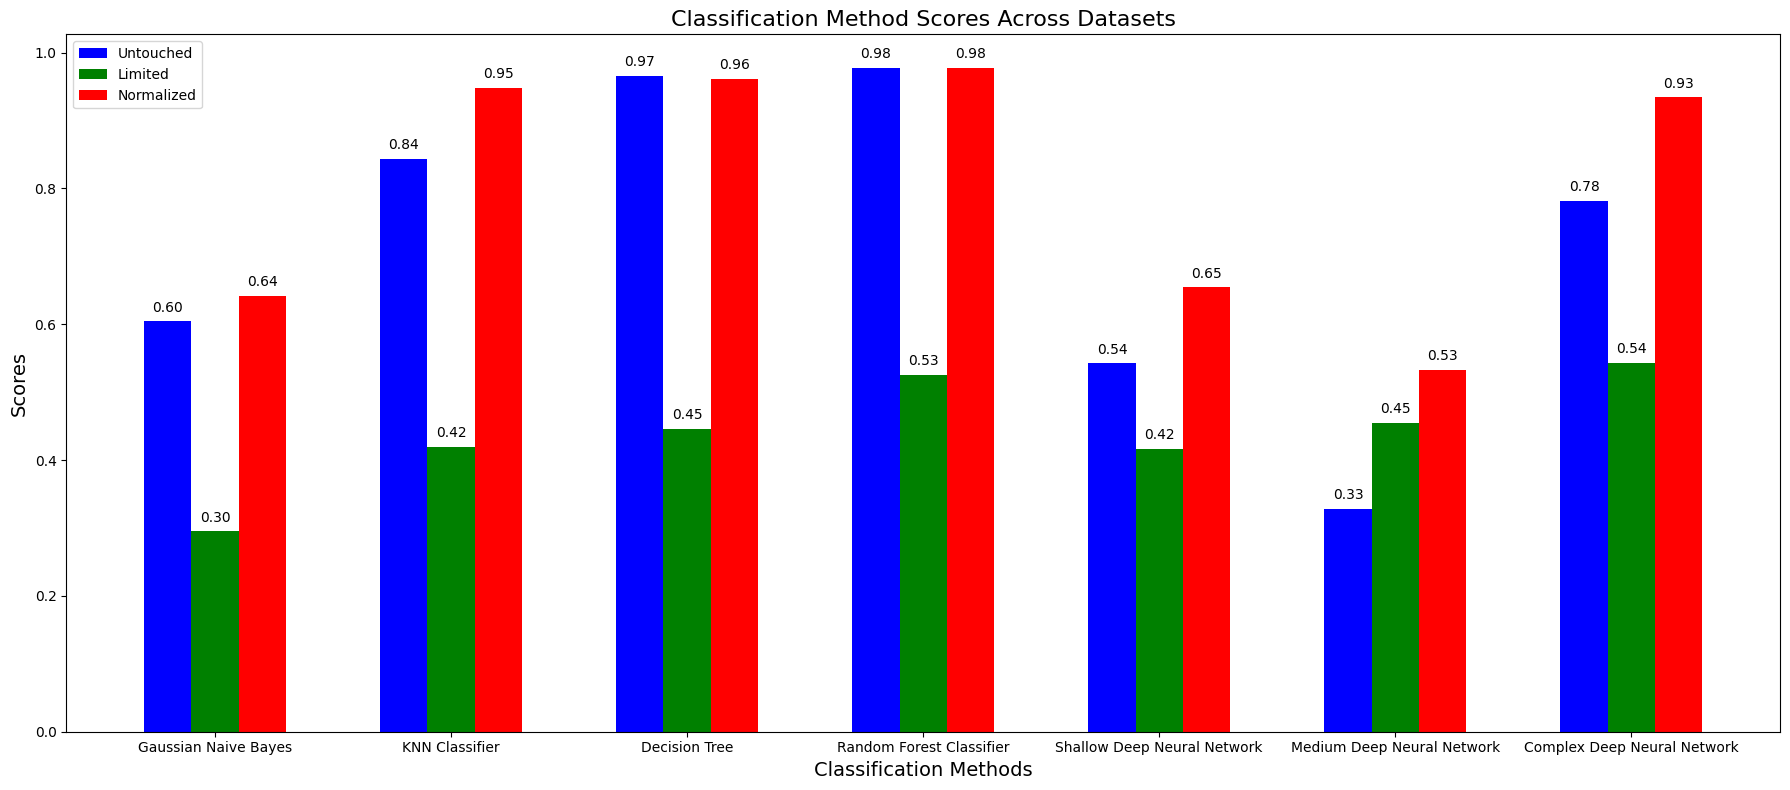

In [89]:
# Graphing curtosy of ChatGPT

methods = list(results[setnames[0]].keys())
scores = [[results[set][method] for method in methods] for set in setnames]


# Set up the bar plot
fig, ax = plt.subplots(figsize=(18, 8))

bar_width = 0.4
index = np.arange(len(methods))*2

colors = ['b', 'g', 'r']

# Plot bars
for i, dataset in enumerate(setnames):
    ax.bar(index + i * bar_width, scores[i], bar_width, label=dataset, color=colors[i])

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Classification Methods', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Classification Method Scores Across Datasets', fontsize=16)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(methods)
ax.legend(loc='upper left')

# Add scores on top of bars
for i, dataset in enumerate(setnames):
    for j, method in enumerate(methods):
        ax.text(index[j] + i * bar_width, scores[i][j] + 0.01, f'{scores[i][j]:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

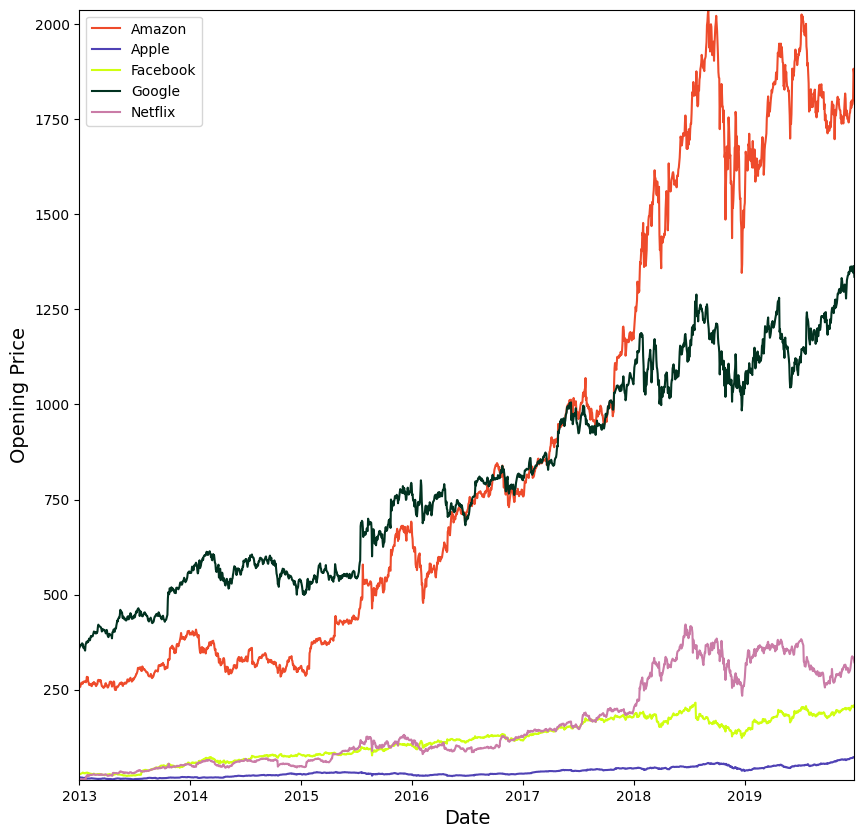

In [47]:
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot()


ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Opening Price', fontsize=14)
ax.set_xticks(np.arange(0,1762, step=252), ['2013', '2014', '2015', '2016', '2017', '2018', '2019'])
plt.margins(0)

colors = ["#EE4B2B", "#4f42b5", "#D0FF11", "#013220", "#ca7ca7"]
for i in range(len(datasets)):
  ax.plot(range(len([x[1] for x in betasets[i]])), [x[1] for x in betasets[i]], color=colors[i], label=datapools[i])
ax.legend(loc='upper left')

plt.show()

{'Untouched': {'Gaussian Naive Bayes': 0.6034989316239316, 'KNN Classifier': 0.8567040598290598, 'Decision Tree': 1.0, 'Random Forest Classifier': 1.0, 'Shallow Deep Neural Network': 0.5353899572649573, 'Medium Deep Neural Network': 0.3326655982905983, 'Complex Deep Neural Network': 0.7819177350427351}, 'Limited': {'Gaussian Naive Bayes': 0.3003472222222222, 'KNN Classifier': 0.5614316239316239, 'Decision Tree': 1.0, 'Random Forest Classifier': 1.0, 'Shallow Deep Neural Network': 0.42908653846153844, 'Medium Deep Neural Network': 0.47449252136752135, 'Complex Deep Neural Network': 0.5592948717948718}, 'Normalized': {'Gaussian Naive Bayes': 0.6302083333333334, 'KNN Classifier': 0.9600694444444444, 'Decision Tree': 1.0, 'Random Forest Classifier': 1.0, 'Shallow Deep Neural Network': 0.6386217948717948, 'Medium Deep Neural Network': 0.530715811965812, 'Complex Deep Neural Network': 0.9432425213675214}}
(3, 7) (3, 7)


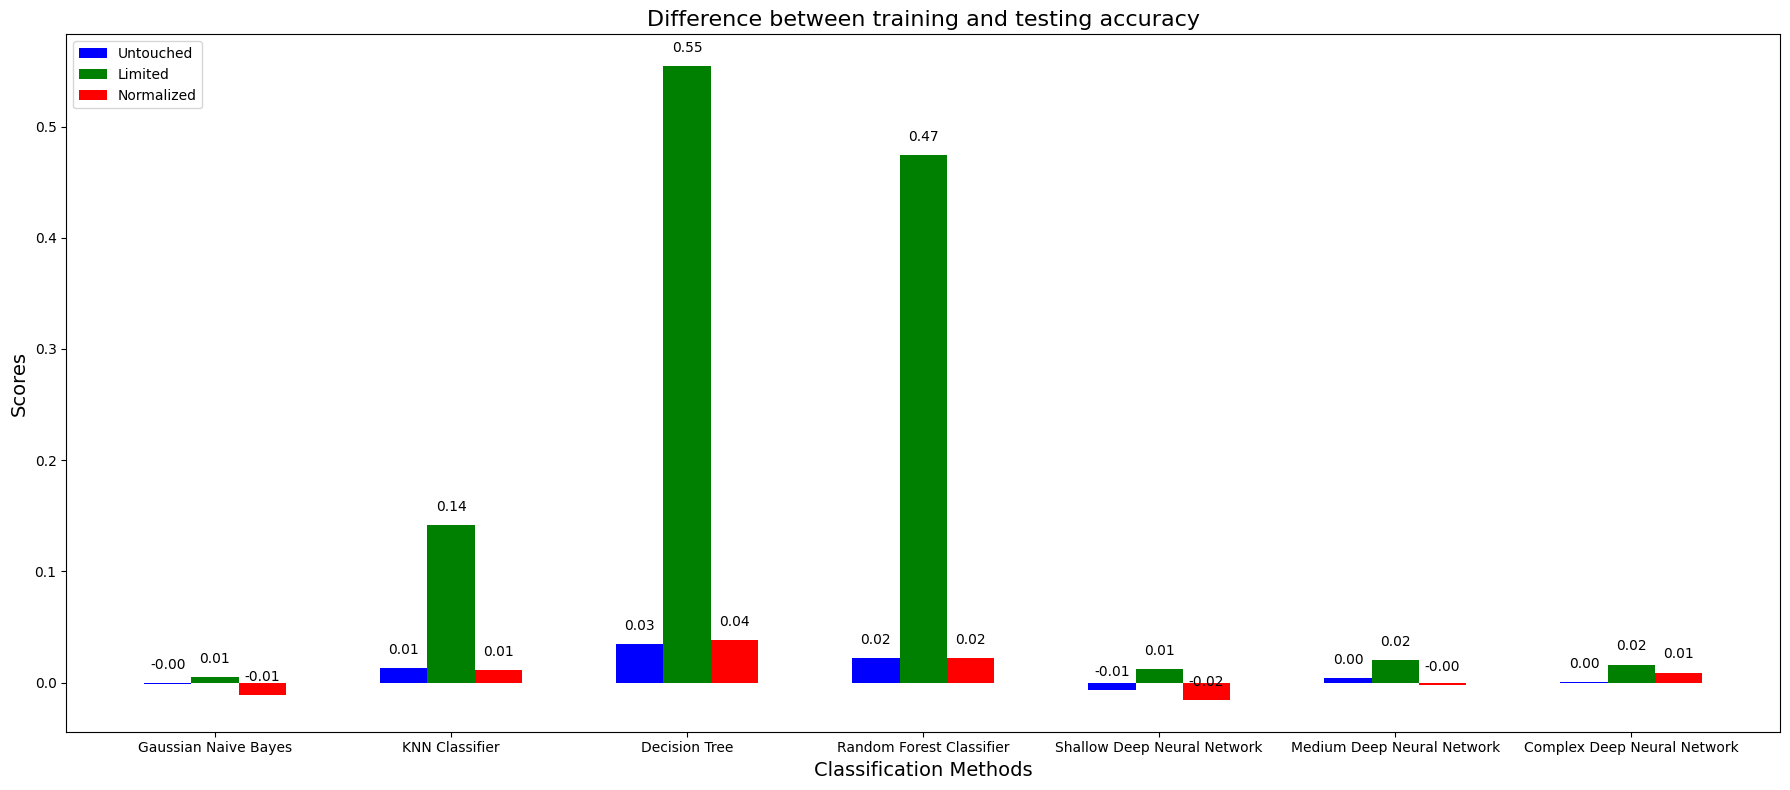

In [91]:
# Graphing curtosy of ChatGPT

print(reported)

methods = list(results[setnames[0]].keys())
scores = [[results[set][method] for method in methods] for set in setnames]
supposed = [[reported[set][method] for method in methods] for set in setnames]

output = [[y - x for x, y in zip(scores[i], supposed[i])] for i in range(len(scores))]

print(np.shape(scores), np.shape(supposed))

# Set up the bar plot
fig, ax = plt.subplots(figsize=(18, 8))

bar_width = 0.4
index = np.arange(len(methods))*2

colors = ['b', 'g', 'r']

# Plot bars
for i, dataset in enumerate(setnames):
    ax.bar(index + i * bar_width, output[i], bar_width, label=dataset, color=colors[i])

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Classification Methods', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Difference between training and testing accuracy', fontsize=16)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(methods)
ax.legend(loc='upper left')

# Add scores on top of bars
for i, dataset in enumerate(setnames):
    for j, method in enumerate(methods):
        ax.text(index[j] + i * bar_width, output[i][j] + 0.01, f'{output[i][j]:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

24.241596937179565
(3, 7) (3, 7)


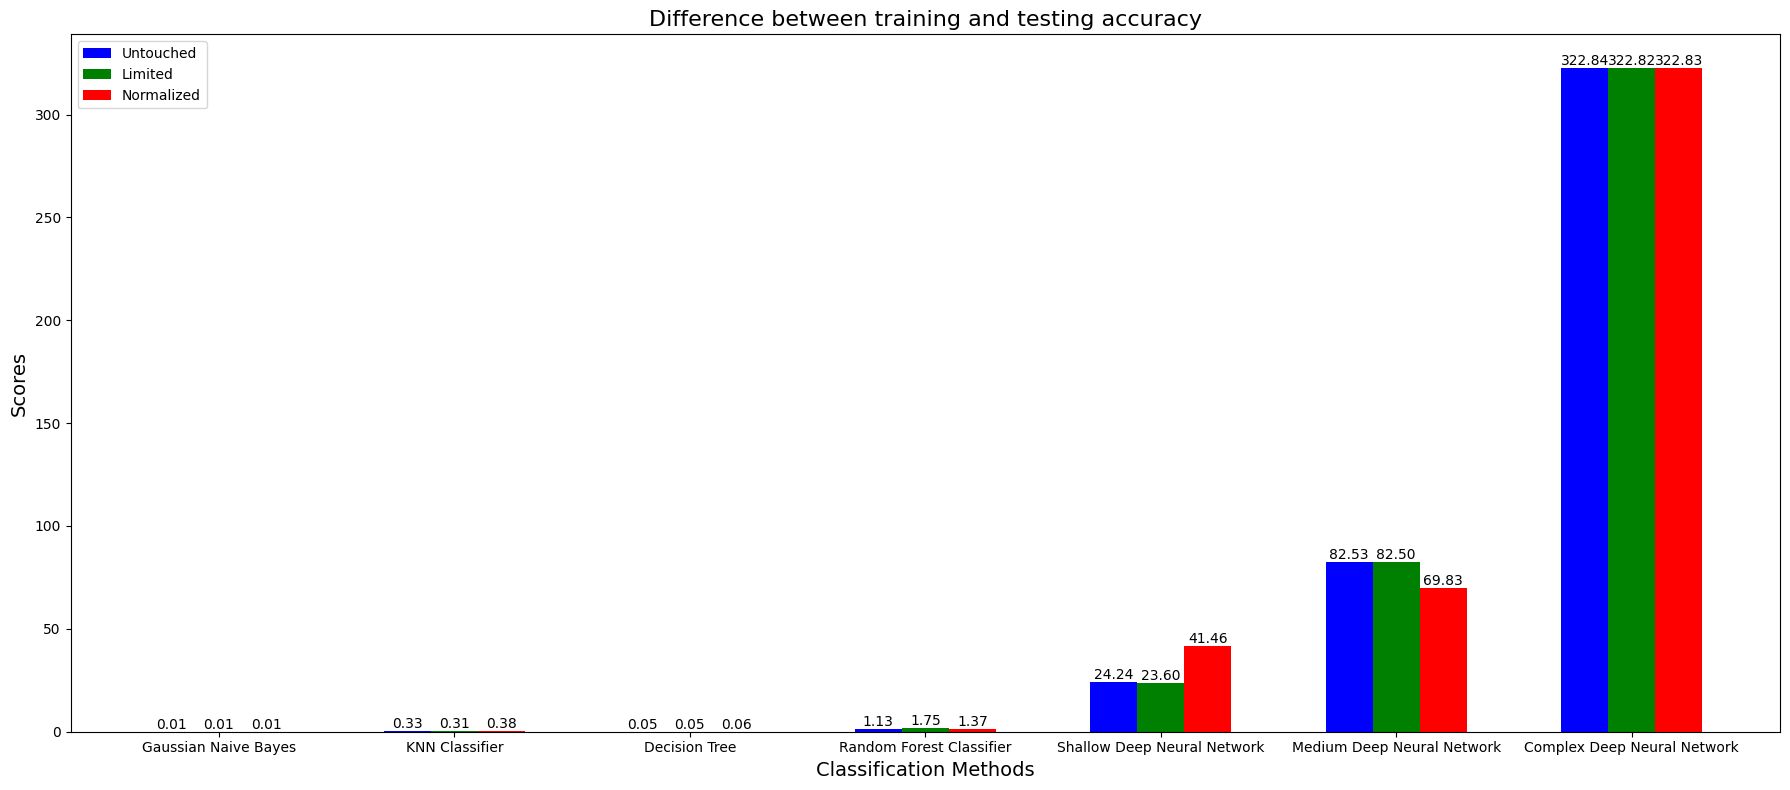

In [98]:

# Graphing curtosy of ChatGPT

print(times["Untouched"]["Shallow Deep Neural Network"])

methods = list(results[setnames[0]].keys())
time_taken = [[times[set][method] for method in methods] for set in setnames]

print(np.shape(scores), np.shape(supposed))

# Set up the bar plot
fig, ax = plt.subplots(figsize=(18, 8))

bar_width = 0.4
index = np.arange(len(methods))*2

colors = ['b', 'g', 'r']

# Plot bars
for i, dataset in enumerate(setnames):
    ax.bar(index + i * bar_width, time_taken[i], bar_width, label=dataset, color=colors[i])

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Classification Methods', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Difference between training and testing accuracy', fontsize=16)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(methods)
ax.legend(loc='upper left')

# Add scores on top of bars
for i, dataset in enumerate(setnames):
    for j, method in enumerate(methods):
        ax.text(index[j] + i * bar_width, time_taken[i][j] + 0.01, f'{time_taken[i][j]:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()